In [1]:
#!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
#!unzip data.zip

In [2]:
#import os
#if os.environ.get("PYTHONHASHSEED") != "0":
#  raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

SEED=42
np.random.seed(SEED)
rn.seed(SEED)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(SEED)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
from keras import __version__ as keras_version
print("keras version: {}".format(keras_version))
from tensorflow import __version__ as tf_version
print("tensorflow version:{}".format(tf_version ))

keras version: 2.2.4
tensorflow version:1.13.1


## Get Data and Generate Dataset

In [4]:
DATASET_PATH="/home/milhouse/datasets/steering_angle/data2"
!ls $DATASET_PATH

driving_log.csv  IMG


In [5]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
#import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
## Store data
#datadir = 'self-driving-car-data-track-1'
datadir = DATASET_PATH
#columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
pd.set_option('display.max_colwidth', -1)
data.head()


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [7]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.shape)
data.head()

(8033, 7)


,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,center_2016_12_01_13_31_13_279.jpg,left_2016_12_01_13_31_13_279.jpg,right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,center_2016_12_01_13_31_13_381.jpg,left_2016_12_01_13_31_13_381.jpg,right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,center_2016_12_01_13_31_13_482.jpg,left_2016_12_01_13_31_13_482.jpg,right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [8]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  

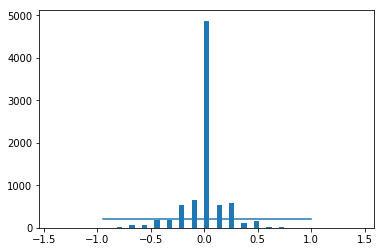

In [9]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

### Preprocessing required
# 1.- Balance dataset

Total data: 8033
Removed: 6169
Remaining: 1864


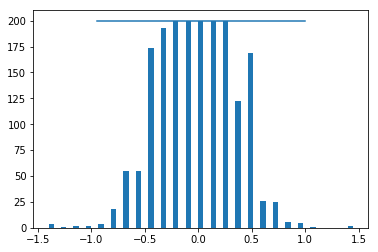

In [10]:
## Unskew data: for bins with >samples_per_bin, shuffle them and remove enough to have samples_per_bin 
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Training Samples: 1491
Valid Samples: 373


Text(0.5, 1.0, 'Validation set')

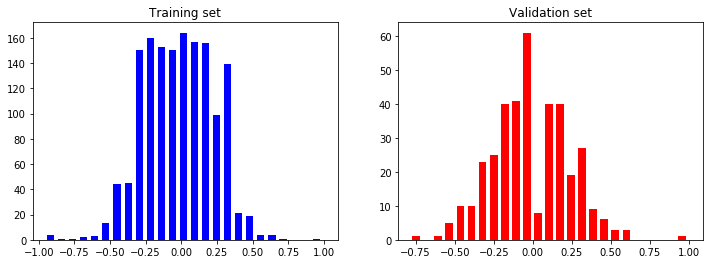

In [11]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

## Split data into training and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

(1491, 160, 320, 3)


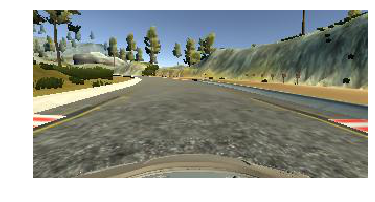

In [12]:
X_train = np.array(list(map(lambda x:npimg.imread(x), X_train)))
X_valid = np.array(list(map(lambda x:npimg.imread(x), X_valid)))
plt.imshow(X_train[rn.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
IMG_SIZE = X_train[0].shape

## More preprocessing

Training Samples: 1491
Valid Samples: 373


Text(0.5, 1.0, 'Validation set')

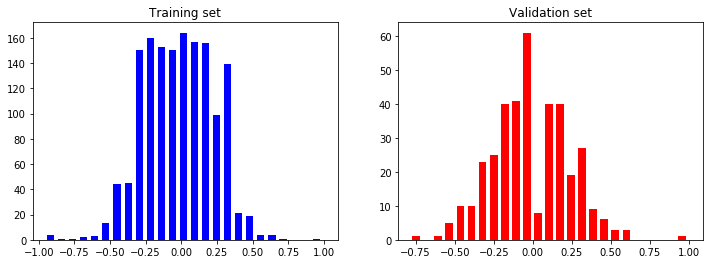

In [13]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

## Split data into training and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')



In [14]:
def img_preprocess(img):
    img = npimg.imread(img)
    y_crop = 60
    x_pix = 160
    y_pix = 100
    """
    Resize and Normalize images
    :param path_img: image in bgr
    :param x_pix: final x pixels size
    :param y_pix: final y pixels size
    :param y_crop: y pixels to crop image
    :return: processed image
    """
    b, g, r = cv2.split(img)  # get b,g,r
    img = cv2.merge([r, g, b])  # switch it to rgb
    # normalize image:
    cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # crop image:
    img = img[y_crop:, :, :]
    # resize image:
    img = cv2.resize(img, (x_pix, y_pix), interpolation=cv2.INTER_CUBIC)
    return img

(1491, 100, 160, 3)
(100, 160, 3)


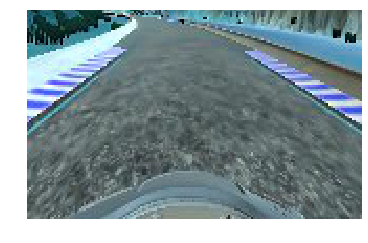

In [15]:
## Preprocess data
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))
plt.imshow(X_train[rn.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
IMG_SIZE=X_train[0].shape
print(IMG_SIZE)

## Our model

In [16]:
def nvidia_inspired_model():
############################################################
# Define model
############################################################
  model = Sequential()
  model.add(
      Convolution2D(filters=24, kernel_size=(5,5), padding='valid', strides=(2, 2),
                    input_shape=IMG_SIZE, activation='relu'))
  
  model.add(Convolution2D(filters=36, kernel_size=(5,5), padding='valid', strides=(2, 2), activation='relu'))
 
  model.add(Convolution2D(filters=48, kernel_size=(5,5), padding='valid', strides=(2, 2), activation='relu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
  model.add(Flatten())
  model.add(Dense(1164, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))

  # keras model compile, choose optimizer and loss func
  model.compile(optimizer='adam', loss='mse')
  return model

In [17]:
K.clear_session()
mycallback = keras.callbacks.TensorBoard(log_dir='./logs/2')
model = nvidia_inspired_model()
optimizer = Adam(lr=1e-3, clipnorm=1.)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1, callbacks=[mycallback])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1491 samples, validate on 373 samples
Epoch 1/30
1491/1491 [==============================] - 10s 6ms/step - loss: 21.4496 - val_loss: 0.0542
Epoch 2/30
1491/1491 [==============================] - 6s 4ms/step - loss: 0.0573 - val_loss: 0.0350
Epoch 3/30
1491/1491 [==============================] - 6s 4ms/step - loss: 0.0357 - val_loss: 0.0296
Epoch 4/30
1491/1491 [==============================] - 7s 4ms/step - loss: 0.0245 - val_loss: 0.0231
Epoch 5/30
1491/1491 [==============================] - 6s 4ms/step - loss: 0.0197 - val_loss: 0.0218
Epoch 6/30
1491/1491 [==============================] - 7s 5ms/step - loss: 0.0176 - val_loss: 0.0199
Epoch 7/30
1491/1491 [==============================] - 6s 4ms/step - loss: 0.0147 - val_loss: 0.0182
Epoch 8/30
1491/1491 [==============================] - 6s 4ms/step - loss: 0.0131 - val_loss: 0.0194
Epoch 9/30
1491

Text(0.5, 0, 'Epoch')

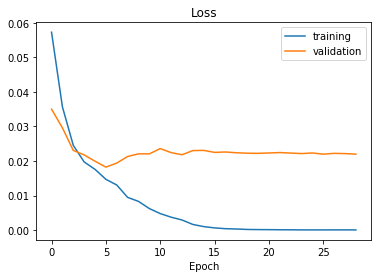

In [18]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [21]:
PROJECT_PATH="/home/milhouse/projects/car-behavioral-cloning/"
model.save('{}/models/model_meetup.h5'.format(PROJECT_PATH))
!/home/milhouse/miniconda3/envs/car-behavioral-cloning-keras2/bin/python $PROJECT_PATH/drive_100x160.py $PROJECT_PATH/models/model_meetup.h5 $PROJECT_PATH/models/images_model_meetup 10 & $PROJECT_PATH/beta_simulator_linux/beta_simulator.x86_64

Found path: /home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator.x86_64
Mono path[0] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Managed'
Mono path[1] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono'
Mono config path = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono/etc'
displaymanager : xrandr version warning. 1.5
client has 4 screens
displaymanager screen (0)(eDP1): 1366 x 768
Using libudev for joystick management


Importing game controller configs
Using TensorFlow backend.
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 core

In [22]:
!convert $PROJECT_PATH/models/images_model_meetup/*5.jpg $PROJECT_PATH/models/images_model_keras_nvidia.gif

<!--<img src="../models/images_model_keras_nvidia.gif" width="800">-->

<!--<img src="../models/images_model_keras_nvidia.gif" width="800">-->